In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\mcmul\AppData\Local\Temp\ipykernel_15012\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

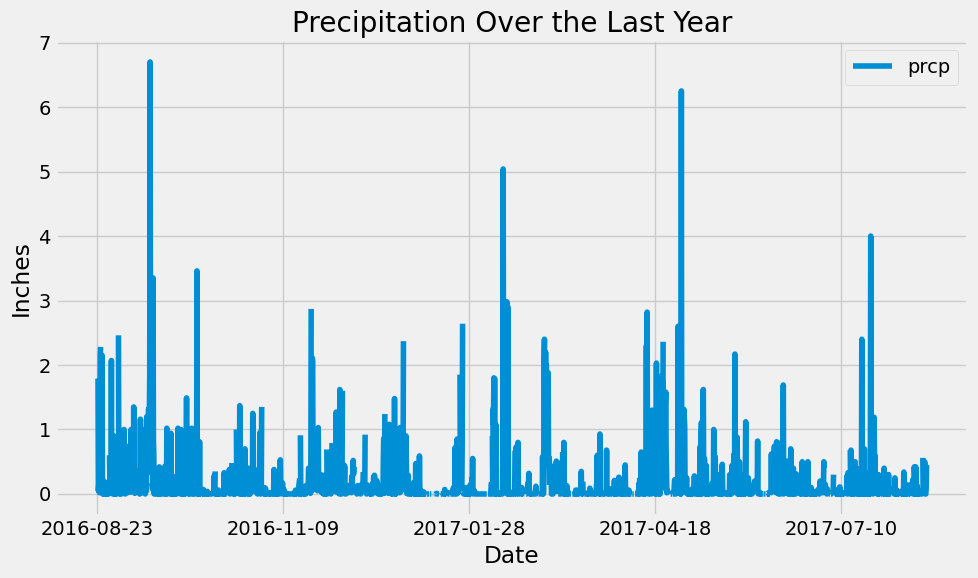

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = pd.to_datetime(most_recent_date) 
most_recent_date_formatted = most_recent_date.strftime('%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_earlier = most_recent_date - pd.DateOffset(years=1)
one_year_earlier_formatted = one_year_earlier.strftime('%Y-%m-%d')
# Perform a query to retrieve the data and precipitation scores
scores_query = session.query(Measurement.date, Measurement.prcp)\
                 .filter(Measurement.date >= one_year_earlier_formatted)\
                 .filter(Measurement.date <= most_recent_date_formatted)\
                 .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
query_df = pd.DataFrame(scores_query, columns=['date', 'prcp'])

# Sort the dataframe by date
query_df = query_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
query_df.set_index('date', inplace=True)
query_df.plot(figsize=(10, 6), title="Precipitation Over the Last Year")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = query_df.describe()
summary_statistics

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_number_stations = session.query(func.count(func.distinct(Station.station))).scalar()
total_number_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all())

for station, count in most_active_stations:
    print(f"Station (ID): {station}, Number of Observations: {count}")

Station (ID): USC00519281, Number of Observations: 2772
Station (ID): USC00519397, Number of Observations: 2724
Station (ID): USC00513117, Number of Observations: 2709
Station (ID): USC00519523, Number of Observations: 2669
Station (ID): USC00516128, Number of Observations: 2612
Station (ID): USC00514830, Number of Observations: 2202
Station (ID): USC00511918, Number of Observations: 1979
Station (ID): USC00517948, Number of Observations: 1372
Station (ID): USC00518838, Number of Observations: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]
temperature_statistics = (session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all())
lowest_temperature, highest_temperature, average_temperature = temperature_statistics[0]

print(f"Most Active Station (ID): {most_active_station}")
print(f"Average Recorded Temperature: {average_temperature:.2f} °F")
print(f"Highest Recorded Temperature: {highest_temperature} °F")
print(f"Lowest Recorded Temperature: {lowest_temperature} °F")

Most Active Station (ID): USC00519281
Average Recorded Temperature: 71.66 °F
Highest Recorded Temperature: 85.0 °F
Lowest Recorded Temperature: 54.0 °F


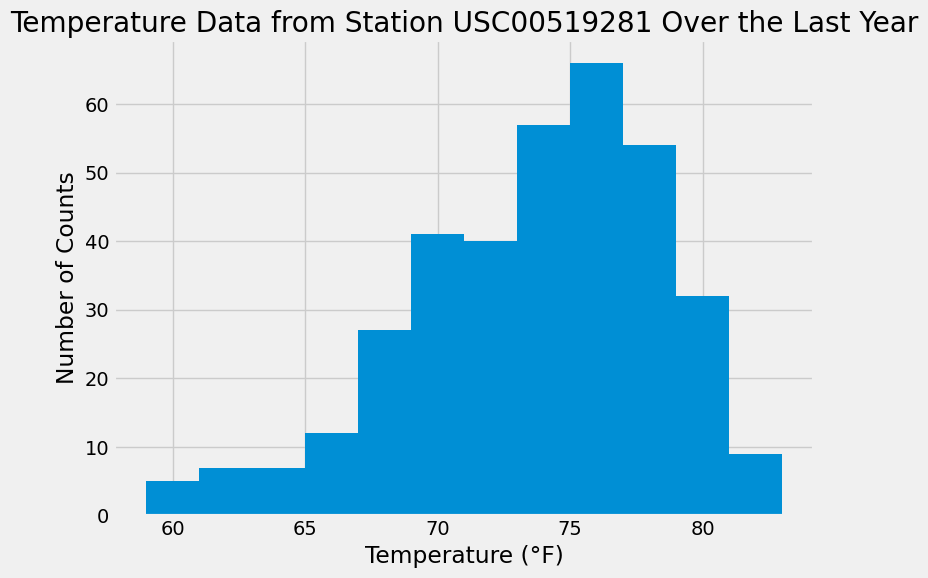

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()[0]

# Find the most recent date and calculate last 12 months
most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station_id).scalar()
most_recent_date = pd.to_datetime(most_recent_date)
most_recent_date_formatted = most_recent_date.strftime('%Y-%m-%d')
one_year_earlier = most_recent_date - pd.DateOffset(years=1)
one_year_earlier_formatted = one_year_earlier.strftime('%Y-%m-%d')



# Query to retrieve temperature data for the last 12 months for the most active station
query_df2 = session.query(Measurement.date, Measurement.tobs)\
                 .filter(Measurement.station == most_active_station_id)\
                 .filter(Measurement.date >= one_year_earlier_formatted)\
                 .filter(Measurement.date <= most_recent_date_formatted)\
                 .all()

# Convert query results to DataFrame
df = pd.DataFrame(query_df2, columns=['date', 'tobs'])

# Plot histogram of TOBS data
plt.figure(figsize=(8, 6))
plt.hist(df['tobs'], bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Number of Counts')
plt.title(f'Temperature Data from Station {most_active_station_id} Over the Last Year')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
